In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


Using TensorFlow backend.


In [6]:
test = pd.read_csv("../input/test.tsv", sep='\t')
train = pd.read_csv("../input/train.tsv", sep="\t")

In [7]:
train = train[["Phrase", "Sentiment"]]
train['Phrase'] = train['Phrase'].apply(lambda x: x.lower())
train

,Phrase,Sentiment
0,a series of escapades demonstrating the adage ...,1
1,a series of escapades demonstrating the adage ...,2
2,a series,2
3,a,2
4,series,2
5,of escapades demonstrating the adage that what...,2
6,of,2
7,escapades demonstrating the adage that what is...,2
8,escapades,2
9,demonstrating the adage that what is good for ...,2


In [8]:
train["Sentiment"].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [9]:
lens = []
for idx, row in train.iterrows():
    lens.append(len(row["Phrase"]))
lens

[188,
 77,
 8,
 1,
 6,
 68,
 2,
 65,
 9,
 55,
 23,
 13,
 9,
 3,
 5,
 31,
 4,
 26,
 4,
 21,
 2,
 18,
 4,
 13,
 3,
 9,
 5,
 110,
 108,
 7,
 4,
 100,
 95,
 91,
 12,
 10,
 6,
 1,
 78,
 13,
 4,
 8,
 5,
 64,
 12,
 51,
 6,
 44,
 3,
 40,
 4,
 35,
 32,
 26,
 7,
 18,
 2,
 15,
 4,
 10,
 7,
 5,
 1,
 74,
 55,
 4,
 50,
 38,
 5,
 32,
 30,
 17,
 13,
 3,
 12,
 11,
 18,
 16,
 8,
 5,
 7,
 100,
 36,
 9,
 4,
 4,
 26,
 23,
 18,
 6,
 11,
 8,
 2,
 4,
 63,
 13,
 11,
 9,
 1,
 7,
 49,
 47,
 5,
 41,
 4,
 36,
 11,
 9,
 4,
 4,
 24,
 7,
 16,
 7,
 8,
 3,
 152,
 150,
 101,
 34,
 32,
 10,
 21,
 9,
 11,
 66,
 63,
 15,
 11,
 47,
 3,
 43,
 39,
 8,
 30,
 28,
 8,
 19,
 17,
 10,
 6,
 6,
 48,
 45,
 26,
 23,
 21,
 13,
 7,
 2,
 18,
 16,
 5,
 10,
 4,
 5,
 60,
 58,
 10,
 47,
 22,
 18,
 24,
 22,
 12,
 9,
 124,
 41,
 14,
 12,
 26,
 23,
 11,
 6,
 4,
 11,
 82,
 80,
 31,
 6,
 24,
 2,
 21,
 19,
 7,
 11,
 48,
 2,
 45,
 19,
 15,
 5,
 9,
 25,
 10,
 14,
 7,
 6,
 52,
 11,
 40,
 38,
 17,
 7,
 9,
 5,
 3,
 20,
 18,
 15,
 13,
 8,
 4,
 112,
 14,

(0.0, 8890.0)

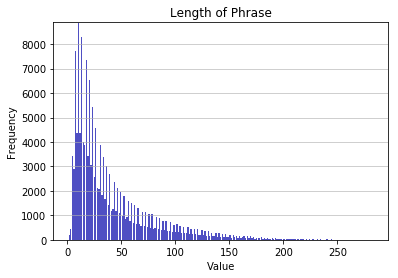

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=lens, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Length of Phrase')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [12]:
max_fatures = 100
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(train['Phrase'].values)
X = tokenizer.texts_to_sequences(train['Phrase'].values)
X = pad_sequences(X)
X

array([[ 0,  0,  0, ...,  3,  2, 42],
       [ 0,  0,  0, ..., 46, 13,  1],
       [ 0,  0,  0, ...,  0,  0,  2],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

In [13]:
####### BUILD model ##########
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 128)           12800     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 985       
Total params: 268,585
Trainable params: 268,585
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
####### convert to 1-hot vector #######
Y = pd.get_dummies(train['Sentiment']).values
Y

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(104560, 30) (104560, 5)
(51500, 30) (51500, 5)


In [24]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("model", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [25]:
batch_size = 32
model.fit(X, Y, validation_split=0.33, epochs = 1, batch_size=batch_size, verbose = 1, callbacks=[checkpoint])

Train on 104560 samples, validate on 51500 samples
Epoch 1/1
104560/104560 [==============================] - 429s 4ms/step - loss: 1.1525 - acc: 0.5517 - val_loss: 1.2070 - val_acc: 0.5220

Epoch 00001: val_loss improved from inf to 1.20704, saving model to model


In [26]:
test = test[["PhraseId", "Phrase"]]
test['Phrase'] = test['Phrase'].apply(lambda x: x.lower())
X_test = tokenizer.texts_to_sequences(test['Phrase'].values)
X_test = pad_sequences(X_test, maxlen=X.shape[1])
result = model.predict(X_test, batch_size=32, verbose=1)
predictions = [np.argmax(line) for line in result]
res = pd.DataFrame({"PhraseId": test["PhraseId"], "Sentiment": predictions})
res.to_csv("submit.csv", index=False)

66292/66292 [==============================] - 94s 1ms/step
